# 1. Import and Install Dependencies

In [63]:
import cv2
import numpy as np
import os
import shutil
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [64]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp_face_mesh = mp.solutions.face_mesh

In [65]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [66]:
def draw_landmarks(image, results):
    # Draw face mesh
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.face_landmarks, 
            mp_face_mesh.FACEMESH_CONTOURS,
            mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
            mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
        )
    
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.pose_landmarks, 
            mp_holistic.POSE_CONNECTIONS
        )
    
    # Draw hands
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.left_hand_landmarks, 
            mp_holistic.HAND_CONNECTIONS
        )
    
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.right_hand_landmarks, 
            mp_holistic.HAND_CONNECTIONS
        )

In [67]:
def draw_styled_landmarks(image, results):
    # Draw face connections with error checking
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.face_landmarks, 
            mp_face_mesh.FACEMESH_CONTOURS,
            mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
            mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
        )
    
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.pose_landmarks, 
            mp_holistic.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
        )
    
    # Draw hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.left_hand_landmarks, 
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
        )
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.right_hand_landmarks, 
            mp_holistic.HAND_CONNECTIONS, 
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )


In [68]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

[ WARN:0@257.890] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@257.891] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
I0000 00:00:1731086277.960233   37968 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731086277.962263   39387 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.6-arch1.1), renderer: AMD Radeon 680M (radeonsi, rembrandt, LLVM 18.1.8, DRM 3.59, 6.11.6-arch1-1)
W0000 00:00:1731086278.022447   39369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731086278.048196   39379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731086278.051105   39368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single 

In [69]:
draw_landmarks(frame, results)

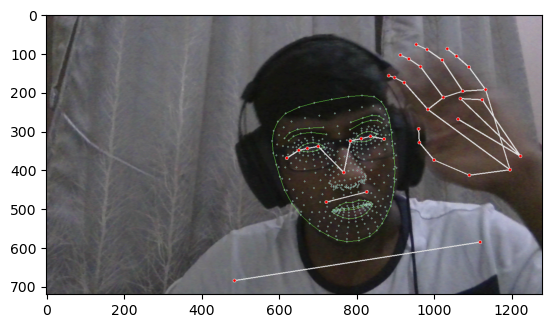

In [70]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [71]:
len(results.face_landmarks.landmark)

468

In [72]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [73]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [74]:
face = (np.array([[res.x, res.y, res.z] 
                  for res in results.face_landmarks.landmark]).flatten() 
        if results.face_landmarks 
        else np.zeros(1404))


In [75]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [76]:
result_test = extract_keypoints(results)

In [77]:
result_test

array([ 0.60052049,  0.56542635, -1.01636255, ...,  0.        ,
        0.        ,  0.        ])

In [78]:
np.save('0', result_test)

In [79]:
np.load('0.npy')

array([ 0.60052049,  0.56542635, -1.01636255, ...,  0.        ,
        0.        ,  0.        ])

# 4. Setup Folders for Collection

In [80]:
# Get path for MP_Data in Epics folder
current_dir = os.path.dirname(os.path.abspath('__file__'))  # Gets Epics folder path
DATA_PATH = os.path.join(current_dir, 'MP_Data')
print(current_dir)
print(DATA_PATH)


# Rest of the code remains same
actions = np.array(['hello', 'thanks', 'iloveyou'])
no_sequences = 30
sequence_length = 30
start_folder = 0

/home/strix/Workspace/ML/Epics
/home/strix/Workspace/ML/Epics/MP_Data


In [81]:
def setup_directories(data_path, actions, no_sequences):
    # Remove existing directory if it exists
    if os.path.exists(data_path):
        shutil.rmtree(data_path)
        print(f"Removed existing directory: {data_path}")
    
    # Create fresh directories
    for action in actions:
        for sequence in range(no_sequences):
            sequence_path = os.path.join(data_path, action, str(sequence))
            os.makedirs(sequence_path, exist_ok=True)
    print("Created fresh directories for data collection")

# Setup fresh directories
setup_directories(DATA_PATH, actions, no_sequences)

Removed existing directory: /home/strix/Workspace/ML/Epics/MP_Data
Created fresh directories for data collection


# 5. Collect Keypoint Values for Training and Testing

In [82]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1731086278.602057   37968 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731086278.603277   39410 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.6-arch1.1), renderer: AMD Radeon 680M (radeonsi, rembrandt, LLVM 18.1.8, DRM 3.59, 6.11.6-arch1-1)
W0000 00:00:1731086278.659474   39393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731086278.685991   39394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731086278.687220   39401 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731086278.687729   39399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabl

KeyboardInterrupt: 

In [83]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}

In [ ]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [ ]:
def load_gesture_data(DATA_PATH, actions, sequence_length):
    sequences, labels = [], []
    
    for action in actions:
        action_path = os.path.join(DATA_PATH, action)
        if not os.path.exists(action_path):
            print(f"Warning: Path {action_path} does not exist")
            continue
            
        # Get valid sequence folders and sort them
        sequence_folders = [f for f in os.listdir(action_path) 
                          if os.path.isdir(os.path.join(action_path, f))]
        sequence_numbers = sorted([int(seq) for seq in sequence_folders])
        
        for sequence in sequence_numbers:
            try:
                window = []
                sequence_path = os.path.join(action_path, str(sequence))
                
                # Check if all frame files exist
                frames_exist = all(os.path.exists(os.path.join(sequence_path, f"{frame_num}.npy")) 
                                 for frame_num in range(sequence_length))
                
                if not frames_exist:
                    print(f"Skipping incomplete sequence: {sequence_path}")
                    continue
                    
                # Load frame data
                for frame_num in range(sequence_length):
                    frame_path = os.path.join(sequence_path, f"{frame_num}.npy")
                    res = np.load(frame_path)
                    window.append(res)
                    
                sequences.append(window)
                labels.append(label_map[action])
                
            except Exception as e:
                print(f"Error processing sequence {sequence} for action {action}: {e}")
                continue
                
    return np.array(sequences), np.array(labels)

# Load the data
sequences, labels = load_gesture_data(DATA_PATH, actions, sequence_length)
print(f"Loaded {len(sequences)} sequences")

Skipping incomplete sequence: /home/strix/Workspace/ML/Epics/MP_Data/hello/2
Skipping incomplete sequence: /home/strix/Workspace/ML/Epics/MP_Data/hello/3
Skipping incomplete sequence: /home/strix/Workspace/ML/Epics/MP_Data/hello/4
Skipping incomplete sequence: /home/strix/Workspace/ML/Epics/MP_Data/hello/5
Skipping incomplete sequence: /home/strix/Workspace/ML/Epics/MP_Data/hello/6
Skipping incomplete sequence: /home/strix/Workspace/ML/Epics/MP_Data/hello/7
Skipping incomplete sequence: /home/strix/Workspace/ML/Epics/MP_Data/hello/8
Skipping incomplete sequence: /home/strix/Workspace/ML/Epics/MP_Data/hello/9
Skipping incomplete sequence: /home/strix/Workspace/ML/Epics/MP_Data/hello/10
Skipping incomplete sequence: /home/strix/Workspace/ML/Epics/MP_Data/hello/11
Skipping incomplete sequence: /home/strix/Workspace/ML/Epics/MP_Data/hello/12
Skipping incomplete sequence: /home/strix/Workspace/ML/Epics/MP_Data/hello/13
Skipping incomplete sequence: /home/strix/Workspace/ML/Epics/MP_Data/hel

In [ ]:
np.array(sequences).shape

(2, 30, 1662)

In [ ]:
np.array(labels).shape

(2,)

In [ ]:
X = np.array(sequences)

In [ ]:
X.shape

(2, 30, 1662)

In [ ]:
y = to_categorical(labels).astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [ ]:
y_test.shape

(1, 1)

# 7. Build and Train LSTM Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
from keras.layers import Input
import tensorflow as tf

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
# Disable GPU usage by setting CUDA device to -1
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [ ]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

2024-11-08 22:45:21.893770: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-08 22:45:21.893804: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: arch
2024-11-08 22:45:21.893811: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: arch
2024-11-08 22:45:21.893999: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 565.57.1
2024-11-08 22:45:21.894017: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 565.57.1
2024-11-08 22:45:21.894021: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 565.57.1


In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)),
    LSTM(128, return_sequences=True, activation='relu'),
    LSTM(64, return_sequences=False, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'), 
    Dense(actions.shape[0], activation='softmax')
])

# Compile model
model.compile(optimizer='Adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 3)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,675 (2.28 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Make Predictions

In [ ]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


In [ ]:
actions[np.argmax(res[4])]

IndexError: index 4 is out of bounds for axis 0 with size 1

In [ ]:
actions[np.argmax(y_test[4])]

IndexError: index 4 is out of bounds for axis 0 with size 1

# 9. Save Weights

In [ ]:
model.save('action.h5')

In [ ]:
del model

In [ ]:
model.load_weights('action.h5')

NameError: name 'model' is not defined

# 10. Evaluation using Confusion Matrix and Accuracy

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[5, 0],
        [0, 4]],

       [[5, 0],
        [0, 4]],

       [[8, 0],
        [0, 1]]], dtype=int64)

In [ ]:
accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [ ]:
from scipy import stats

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only length-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1731086257.101380   37968 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731086257.103387   39286 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.6-arch1.1), renderer: AMD Radeon 680M (radeonsi, rembrandt, LLVM 18.1.8, DRM 3.59, 6.11.6-arch1-1)
W0000 00:00:1731086257.161323   39271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731086257.184523   39268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731086257.185642   39275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731086257.188495   39270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabl

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

NameError: name 'model' is not defined